In [1]:
!date

Thu Oct 29 14:01:07 PDT 2020


# Splitting clusters on isoforms

In [1]:
import pandas as pd
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from scipy import stats
import os
import anndata
import matplotlib.transforms as transforms
import glob
from lazydata import track
import scanpy as sc

def nd(arr):
    return np.asarray(arr).reshape(-1)

def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

INFO:numexpr.utils:Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:get_version:dirname: Trying to get version of get_version from dirname /home/sina/bin/miniconda3/lib/python3.7/site-packages
INFO:get_version:dirname: Failed; Does not match re.compile('get[_-]version-([\\d.]+?)(?:\\.dev(\\d+))?(?:[_+-]([0-9a-zA-Z.]+))?$')
INFO:get_version:git: Trying to get version from git in directory /home/sina/bin/miniconda3/lib/python3.7/site-packages
INFO:get_version:git: Failed; directory is not managed by git
INFO:get_version:metadata: Trying to get version for get_version in dir /home/sina/bin/miniconda3/lib/python3.7/site-packages
INFO:get_version:metadata: Succeeded
INFO:get_version:dirname: Trying to get version of legacy_api_wrap from dirname /home/sina/bin/miniconda3/lib/python3.7/site-packages
INFO:get_version:dirname: Failed; Does not match re.compile('legacy[_-]api[_-]wrap-([\\d.]+

In [2]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

In [3]:
num_TSNE = 2
state = 42
metric = "euclidean"
n_neighbors = 30
num_PCA = 25
num_NCA = 10

# Filtering criteria
cell_threshold = 250
disp_threshold = 0.001

mito_criteria = 10

n_top_genes = 5000

n_bins = 20

flavor="seurat"

scale_clip = 10

In [4]:
import ast

In [5]:
gene = anndata.read_h5ad("../../data/notebook/revision/gene.h5ad")
isoform = anndata.read_h5ad("../../data/notebook/revision/isoform.h5ad")

In [6]:
gene_id = gene.var["gene_id"].values
gene_names = gene.var["gene_name"].values.astype(str)

# Restrict to two isoform genes

In [7]:
gene = gene[:,gene.var["num_isoforms"]>1]

In [8]:
%%time
transcripts = []
l = gene.var.txn_list.values
for sublist in l:
    sublist = ast.literal_eval(sublist)
    for item in sublist:
        transcripts.append(item)

CPU times: user 185 ms, sys: 4.74 ms, total: 189 ms
Wall time: 188 ms


In [9]:
isoform = isoform[:,isoform.var["transcript_id"].isin(transcripts)]

In [10]:
print(gene)
print(isoform)

View of AnnData object with n_obs × n_vars = 6160 × 11891
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_counts', 'percent_mito', 'n_genes', 'pass_count_filter', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'txn_list', 'num_isoforms', 'gene_counts', 'dispersion', 'pass_disp_filter', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'louvain', 'neighbors'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'X', 'log1p', 'norm'
    obsp: 'connectivities', 'distances'
View of AnnData object with n_obs × n_vars = 6160 × 61873
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_counts', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'gene_counts', 'high

# Cluster on the subclasses to see if there is an isoform that splits one 

In [12]:
from sklearn.cluster import KMeans

In [13]:
clusters = np.unique(isoform.obs.cluster_label.values)

In [14]:
%%time

# isoform level

files = []
for c in clusters:
    tmp = isoform[isoform.obs.eval(f"cluster_label== '{c}'")].copy()
    kmeans = KMeans(n_clusters=2, random_state=state).fit(tmp.X)
    tmp.obs["km"] = kmeans.labels_
    files.append(tmp)

CPU times: user 22min 32s, sys: 1min 42s, total: 24min 15s
Wall time: 1min 30s


In [15]:
new_isoform = files[0].concatenate(*files[1:])

In [16]:
%%time

# gene level

files = []
for c in clusters :
    tmp = gene[gene.obs.eval(f"cluster_label== '{c}'")].copy()
    kmeans = KMeans(n_clusters=2, random_state=state).fit(tmp.X)
    tmp.obs["km"] = kmeans.labels_
    files.append(tmp)

CPU times: user 7min 7s, sys: 29.8 s, total: 7min 36s
Wall time: 23.3 s


In [17]:
new_gene = files[0].concatenate(*files[1:])

# Plot new clusters

In [29]:
def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

In [38]:
shape = np.round(np.sqrt(new_isoform.obs.cluster_label.nunique())).astype(int)
n_clusters = new_isoform.obs.cluster_label.nunique()

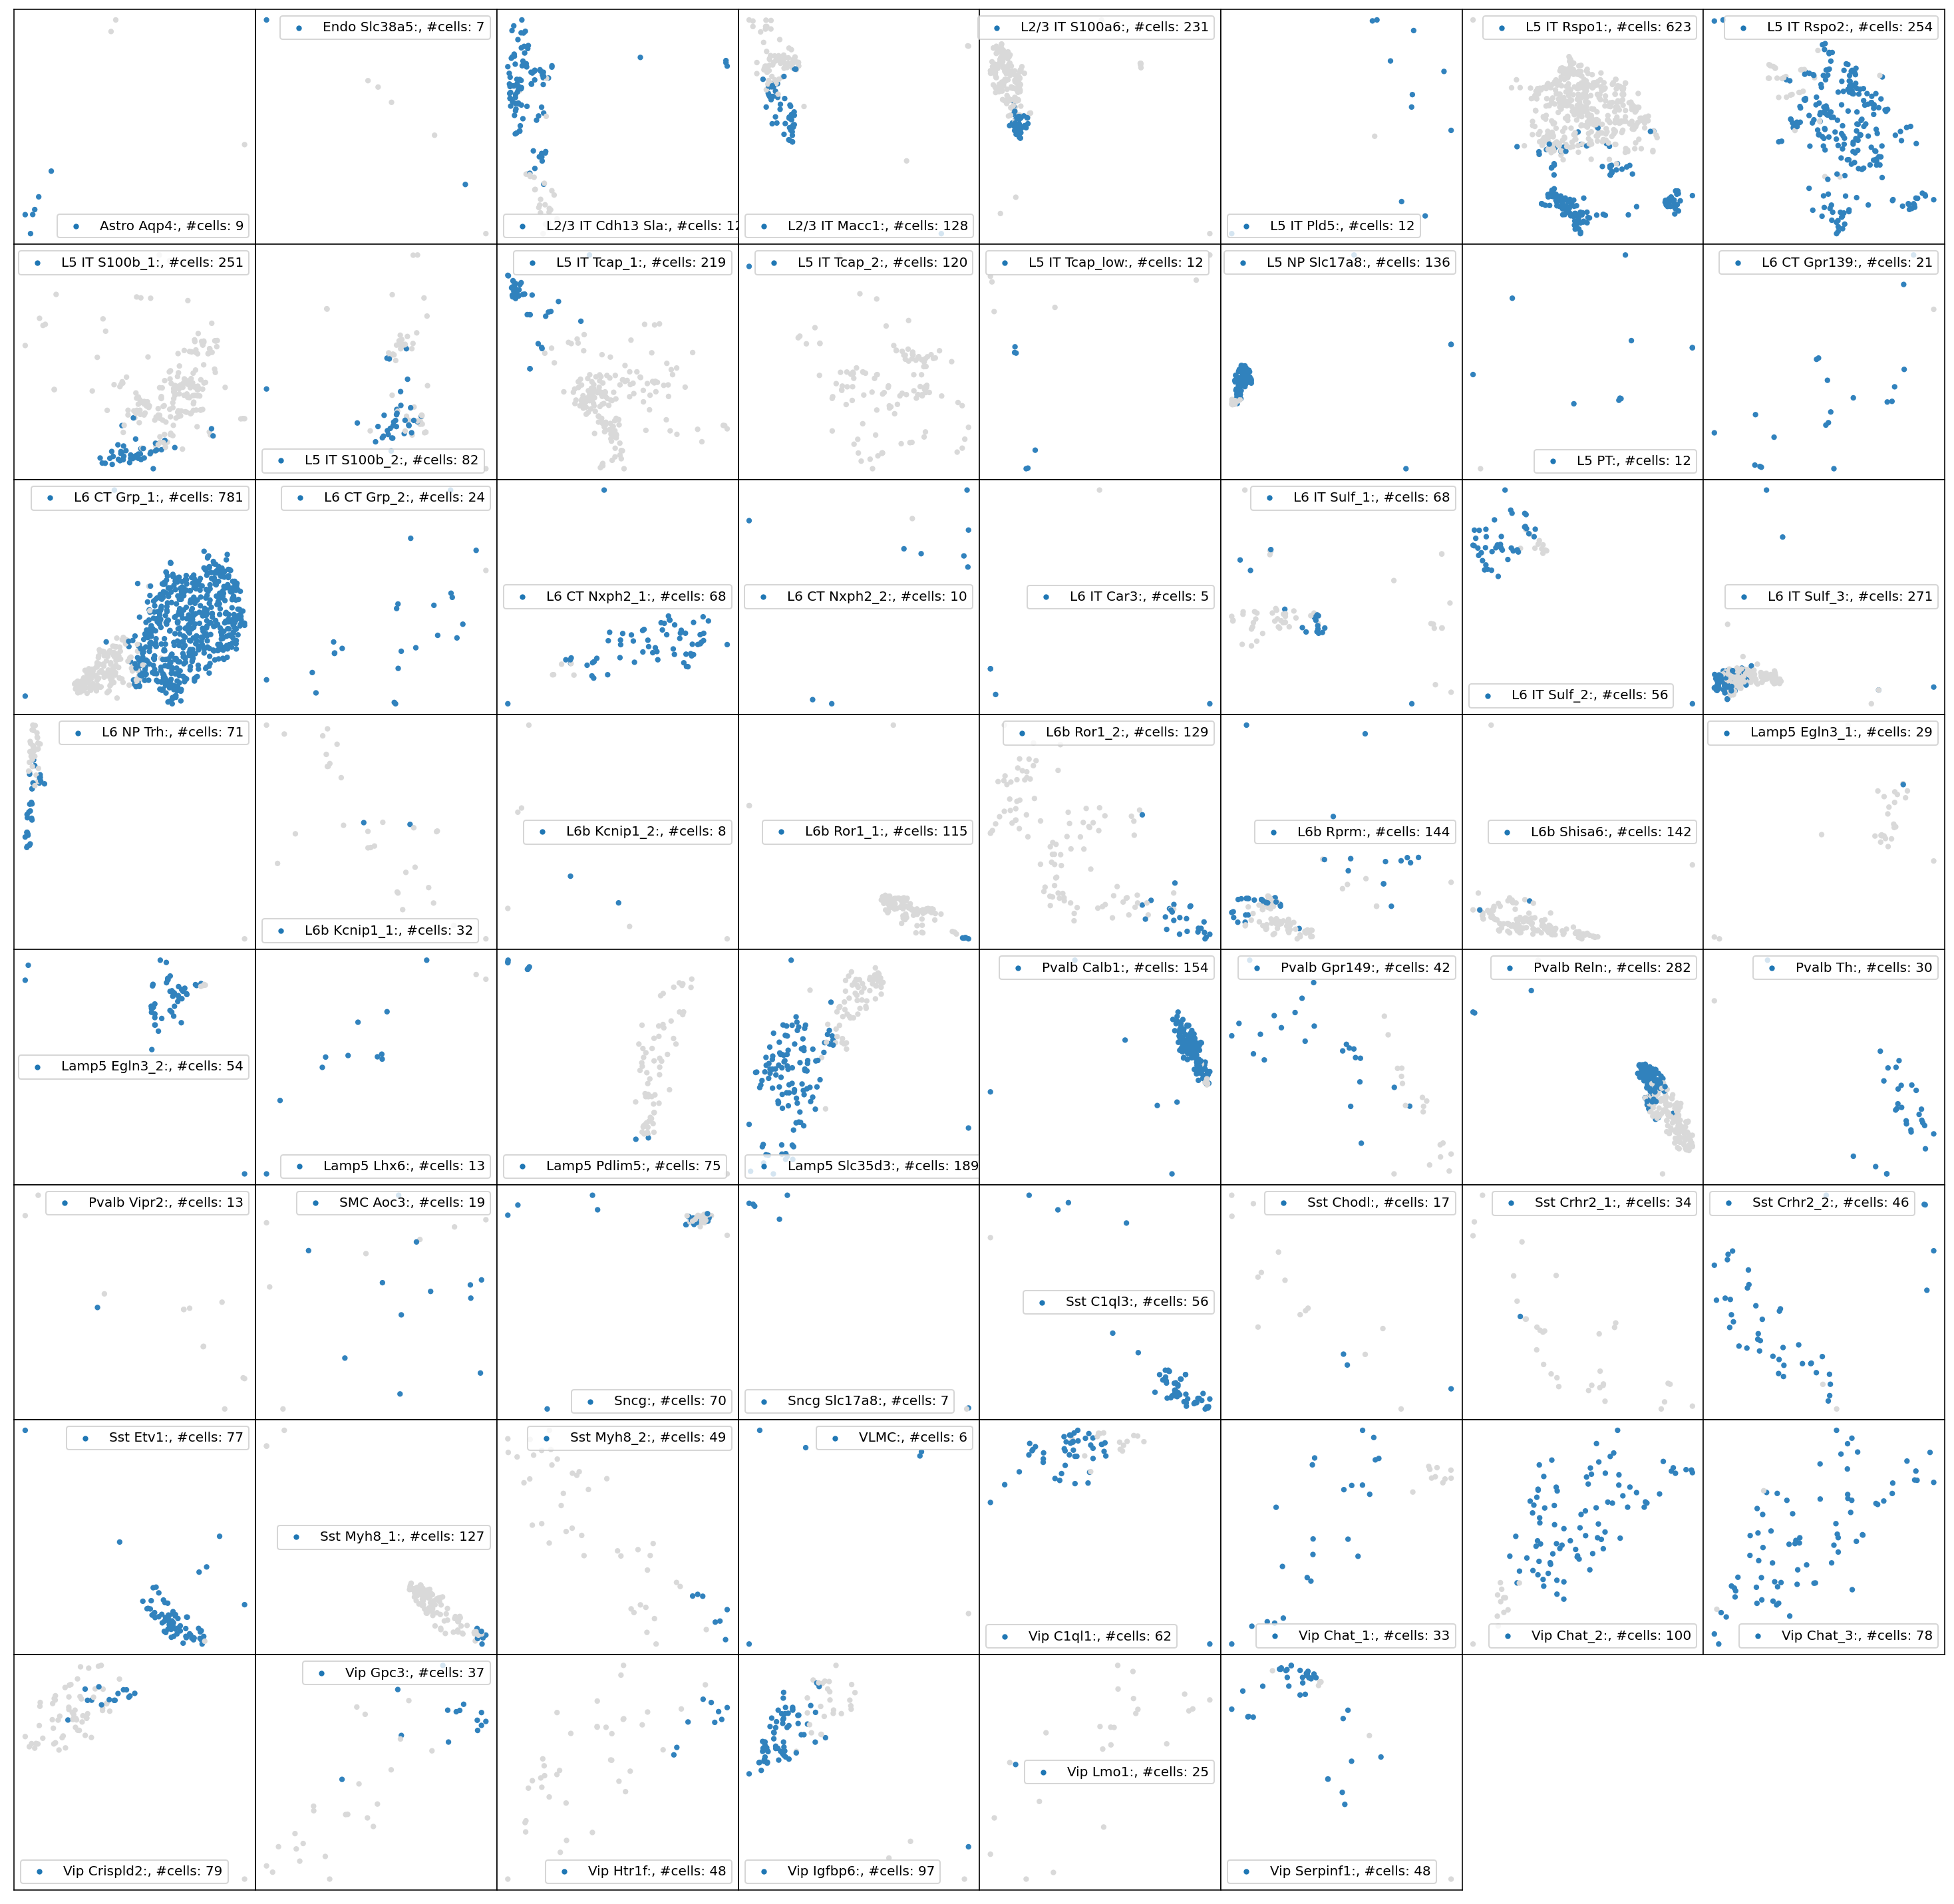

In [41]:
fig, ax = plt.subplots(figsize=(26,26), ncols=shape, nrows=shape)
fig.subplots_adjust(hspace=0, wspace=0)
axs = trim_axs(ax, n_clusters)


for sidx, (ax, cluster) in enumerate(zip(axs, clusters)):
    tmp = new_isoform[new_isoform.obs.eval(f"cluster_label == '{cluster}'")]

    ax = axs[sidx]
    XX = tmp.obsm["X_nca_tsne"]
    x = XX[:,0]
    y = XX[:,1]
    color = tmp.obs.km.astype(int)
    ax.scatter(x, y,s=10, c = color, cmap="tab20c", label=cluster+":, #cells: {:,}".format(x.shape[0]))# label=cluster+", #clusters {:,}".format(np.unique(color).shape[0]))
    ax.legend(fontsize=10)
    ax.set(**{
        "xticks": [],
        "xticklabels": [],
        "yticks": [],
        "yticklabels": [],
    })

fig.show()

In [42]:
isoform = new_isoform[new_isoform.obs.eval("cluster_label == 'L6 CT Grp_1'")].copy()
gene = new_gene[new_gene.obs.eval("cluster_label == 'L6 CT Grp_1'")].copy()

In [43]:
isoform

AnnData object with n_obs × n_vars = 781 × 61873
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_counts', 'leiden', 'louvain', 'km', 'batch'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'gene_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'X', 'log1p', 'norm'

In [44]:
gene

AnnData object with n_obs × n_vars = 781 × 11891
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_counts', 'percent_mito', 'n_genes', 'pass_count_filter', 'leiden', 'louvain', 'km', 'batch'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'txn_list', 'num_isoforms', 'gene_counts', 'dispersion', 'pass_disp_filter', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'X', 'log1p', 'norm'

# determine the isoforms

In [45]:
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ks_2samp, ttest_ind
import numpy as np
import logging

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.basicConfig(format='%(asctime)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S')



def split_by_target(mat, targets, target, axis=0):
    """
    Split the rows of mat by the proper assignment
    
    mat = ndarray
    targets, length is equal to number of components (axis=0) or features (axis=1)
    target is a singular element from unique(assignments/features) 
    """
    if axis==0 and len(targets) != mat.shape[axis]: return -1
    if axis==1 and len(targets) != mat.shape[axis]: return -1
        
    mask = targets == target
    
    if axis==0:
        t_mat = mat[mask]  # target matrix
        c_mat = mat[~mask] # complement matrix
    elif axis==1:
        t_mat = mat[:, mask]  # target matrix
        c_mat = mat[:, ~mask] # complement matrix
    
    return (t_mat, c_mat)

def correct_pval(pval, method):
    nfeat = pval.shape[1]
    
    if method == 'benjamini-hochberg':
        _, pval_corr, _, _ = multipletests(pval, alpha=0.01, method='fdr_bh')
    elif method == 'bonferroni':
        pval_corr = np.minimum(pval * nfeat, 1.0)
        
    return pval_corr

def dexpress(mat, components, features, assignments, **kwargs):
    """
    mat: ndarray
    components: nparray
    features: nparray
    assignments: nparray, length is equal to length of components
    """
    nan_cutoff = kwargs.get("nan_cutoff", 0)
    
    unique = np.unique(assignments)
        
    ncomp = components.shape[0]
    nfeat = features.shape[0]
    nuniq = unique.shape[0]
    
    pval = np.empty((nuniq, nfeat)) # unique assignments by features 
    pval_corr = np.empty((nuniq, nfeat)) # unique assignments by features 
    stat = np.empty((nuniq, nfeat)) # unique assignments by features 
    
    pval.fill(np.nan)
    pval_corr.fill(np.nan)
    stat.fill(np.nan)

    for tidx, t in enumerate(unique):
        logging.debug("{} of {} assignments: {}".format(tidx+1, nuniq, t))
        t_mat, c_mat = split_by_target(mat, assignments, t, axis=0)
        
        pvalue = np.nan
        statistic = np.nan

        # Keep only the genes for which it is in at least nan_cutoff*ncellsinclusters
        mask = np.asarray((t_mat>0).sum(axis=0) > nan_cutoff*t_mat.shape[0]).reshape(-1)

        t_mat = t_mat[:, mask]
        c_mat = c_mat[:, mask]
        # added

        # added
        if mask.sum()>0:
            test = ttest_ind(t_mat, c_mat, nan_policy="propagate", equal_var=False)
            pvalue = test.pvalue
            statistic = test.statistic
                
        pval[tidx,:][mask] = pvalue
        stat[tidx,:][mask] = statistic
    
    return (pval, stat)

In [46]:
%%time
mat           = gene.layers["log1p"].todense()
components    = gene.obs.cell_id.values
gene_features = gene.var.gene_name.values
assignments   = gene.obs.km.values

unique = np.unique(assignments)
nan_cutoff = 0.90 # of elements in cluster
corr_method = "bonferroni"


p_gene_raw, stat = dexpress(mat, components, gene_features, assignments, 
                      nan_cutoff=nan_cutoff)

p_gene = correct_pval(p_gene_raw, corr_method)
s_gene = stat

DEBUG:root:1 of 2 assignments: 0
DEBUG:root:2 of 2 assignments: 1


CPU times: user 170 ms, sys: 12.1 ms, total: 182 ms
Wall time: 179 ms


In [47]:
%%time
mat         = isoform.layers["log1p"].todense() # expects dense matrix
components  = isoform.obs.cell_id.values
features    = isoform.var.transcript_name.values
assignments = isoform.obs.km.values

unique = np.unique(assignments)
nan_cutoff = 0.90 # of elements in cluster
corr_method = "bonferroni"


p_isoform_raw, stat = dexpress(mat, components, features, assignments, 
                      nan_cutoff=nan_cutoff)

p_isoform = correct_pval(p_isoform_raw/2, corr_method)
s_isoform = stat

DEBUG:root:1 of 2 assignments: 0
DEBUG:root:2 of 2 assignments: 1


CPU times: user 412 ms, sys: 360 ms, total: 772 ms
Wall time: 769 ms


In [48]:
repeat_col = gene.var["num_isoforms"]

p1 = p_isoform
p2 = np.repeat(p_gene, repeat_col, axis=1)

s1 = s_isoform
s2 = np.repeat(s_gene, repeat_col, axis=1)

In [49]:
logger.setLevel(logging.ERROR)

In [50]:
alpha = 0.01
tcrit = 0


bool_mask = np.ones(p1.shape, dtype=bool)

p1_mask = np.logical_and(p1<alpha, s1>tcrit)

p2_mask = np.logical_or(np.logical_and(p2>alpha, s2>tcrit), np.logical_and(p2<alpha, s2<tcrit))

mask = np.logical_and(p1_mask, p2_mask)
bool_mask = mask

/home/sina/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys
/home/sina/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/home/sina/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/home/sina/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


In [51]:
bool_mask.sum()

2218

In [52]:
markers_isoform = pd.DataFrame(index=unique, columns=["transcript_name", "p_raw", "p_bonferroni"])

In [53]:
assignments = gene.obs.km.values
unique = np.unique(assignments)

In [54]:
isoform_features = isoform.var.transcript_name.values

for uidx, u in enumerate(unique):
    mask = np.logical_and(bool_mask[uidx], bool_mask.sum(axis=0)==1)
    
    p = p_isoform[uidx][mask]
    p_raw = p_isoform_raw[uidx][mask]
    
    psort = np.argsort(p)
    
    fsorted = features[mask][psort]
    psorted = p[psort]
    p_raw_sorted = p_raw[psort]
    
    markers_isoform.loc[u]["transcript_name"] = fsorted
    markers_isoform.loc[u]["p_raw"] = p_raw_sorted
    markers_isoform.loc[u]["p_bonferroni"] = psorted

In [55]:
markers_isoform

,transcript_name,p_raw,p_bonferroni
0,"[Cox7a2-201_ENSMUST00000034881, Cox7c-203_ENSM...","[1.5501903207363207e-66, 1.8693633085516598e-6...","[4.795746285745919e-62, 5.783155799500842e-62,..."
1,"[Pkm-202_ENSMUST00000163694, Aplp1-201_ENSMUST...","[5.439636155126813e-148, 1.782967836896131e-13...","[1.6828330391308066e-143, 5.515878448613715e-1..."


In [56]:
identified_isoforms = markers_isoform["transcript_name"].explode().astype(str)
identified_isoforms = identified_isoforms[identified_isoforms!="nan"]

In [57]:
identified_genes = identified_isoforms.apply(lambda x: x.split("-")[0:-1][0])

In [58]:
print("{} isoforms from {} genes identified.".format(identified_isoforms.shape[0], identified_genes.nunique()))

2218 isoforms from 1641 genes identified.


In [59]:
markers_isoform = markers_isoform.apply(pd.Series.explode).reset_index()

In [60]:
markers_isoform

,index,transcript_name,p_raw,p_bonferroni
0,0,Cox7a2-201_ENSMUST00000034881,1.55019e-66,4.79575e-62
1,0,Cox7c-203_ENSMUST00000131011,1.86936e-66,5.78316e-62
2,0,Cox6b1-201_ENSMUST00000075738,1.38891e-65,4.29679e-61
3,0,Cox6c-201_ENSMUST00000014457,7.17398e-65,2.21938e-60
4,0,Atp5l-201_ENSMUST00000043675,1.20259e-63,3.7204e-59
...,...,...,...,...
2213,1,Egr1-202_ENSMUST00000165033,2.79204e-07,0.00863759
2214,1,Arf4-203_ENSMUST00000166075,2.84209e-07,0.00879242
2215,1,Klf6-201_ENSMUST00000000080,3.05659e-07,0.00945601
2216,1,Jmjd8-201_ENSMUST00000026832,3.11793e-07,0.00964579


# Plot the gene expression and the marker isoform expression

In [81]:
i = "App-205_ENSMUST00000227654"
# i="Dnm1-206_ENSMUST00000129156"
# i="Lztr1-211_ENSMUST00000232372"
i = "Klf10-201_ENSMUST00000074043"

In [82]:
g = "App_ENSMUSG00000022892"
# g = "Dnm1_ENSMUSG00000026825"
g = gene.var[gene.var.gene_name.str.contains(f"{i.split('-')[0]}")].index.values[0]
print(g)

Klf10_ENSMUSG00000037465


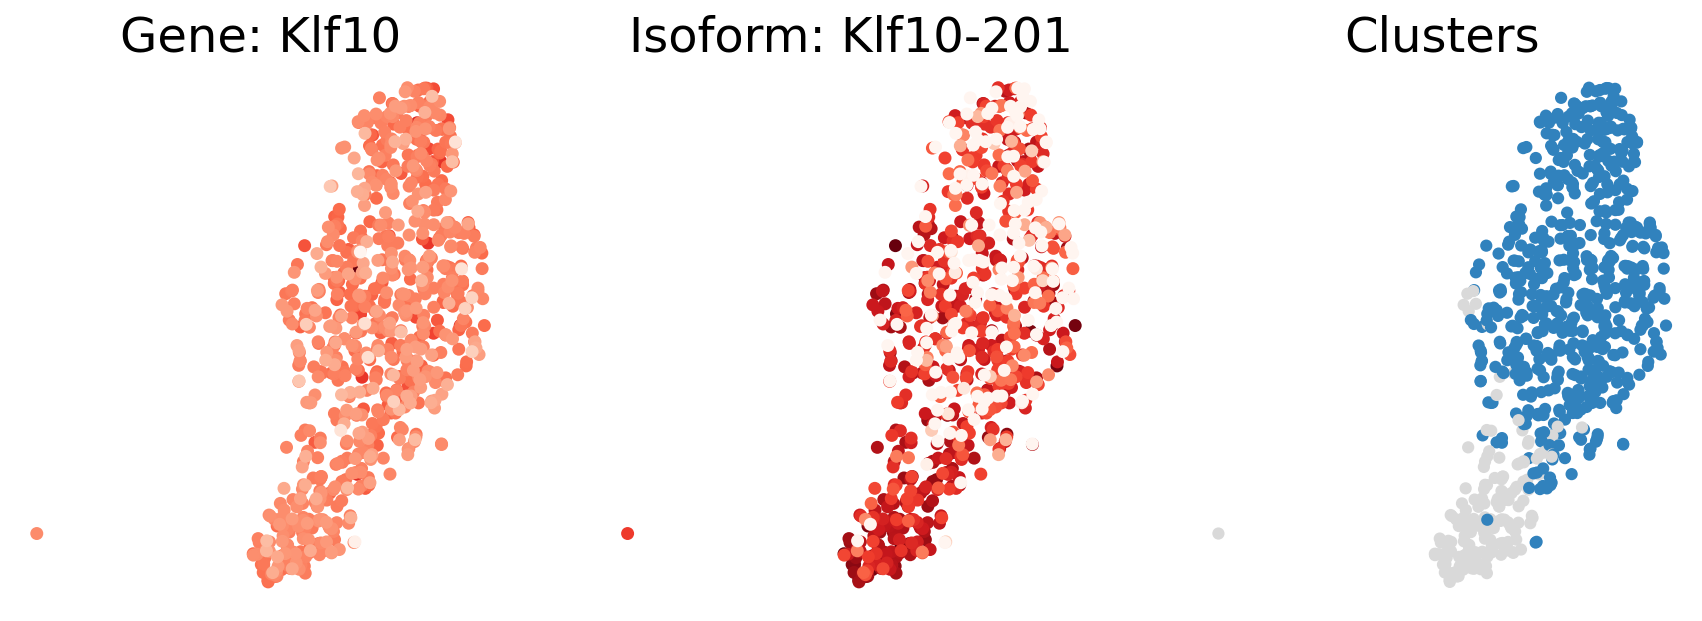

In [85]:
fig, axs = plt.subplots(figsize=(15, 5), ncols=3)

X = gene.obsm["X_nca_tsne"]

Yi = isoform.layers["log1p"][:, isoform.var.index.values == i]
Yg = gene.layers["log1p"][:, gene.var.index.values == g]
pt_size = 30

ax = axs[0] # gene

x = X[:,0]
y = X[:,1]
c = nd(Yg.todense())
argsort = np.argsort(c)[::-1]
x = x[argsort]
y = y[argsort]
c = c[argsort]

ax.scatter(x,y, c=c, cmap="Reds", s=pt_size)
ax.set_axis_off()
ax.set_title(f"Gene: {g.split('_')[0]}")


ax = axs[1] # isoform

x = X[:,0]
y = X[:,1]
c = nd(Yi.todense())
argsort = np.argsort(c)[::-1]
x = x[argsort]
y = y[argsort]
c = c[argsort]

ax.scatter(x,y, c=c, cmap="Reds", s=pt_size)
ax.set_axis_off()
ax.set_title(f"Isoform: {i.split('_')[0]}")

ax = axs[2] # clusters

x = X[:,0]
y = X[:,1]
c = isoform.obs.km.values

ax.scatter(x,y, c=c, cmap="tab20c", s=26)
ax.set_axis_off()
ax.set_title("Clusters")

#plt.savefig(f"../../figures/split_subclass_{i.split('_')[0]}.png",bbox_inches='tight', dpi=300)

fig.show()

# Marker genes

In [64]:
p1 = p_gene
s1 = s_gene

In [65]:
alpha = 0.01
tcrit = 0


bool_mask = np.ones(p1.shape, dtype=bool)

p1_mask = np.logical_and(p1<alpha, s1>tcrit)

bool_mask = p1_mask

/home/sina/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys
/home/sina/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


In [66]:
bool_mask.sum()

2431

In [67]:
assignments = gene.obs.km.values
unique = np.unique(assignments)

In [68]:
unique

array([0, 1], dtype=int32)

In [69]:
markers_gene = pd.DataFrame(index=unique, columns=["gene_name", "p_raw", "p_bonferroni"])

In [70]:
gene_features = gene.var.index.values

for uidx, u in enumerate(unique):
    mask = bool_mask[uidx] # np.logical_and(bool_mask[uidx], bool_mask.sum(axis=0)==1)
    
    p = p_gene[uidx][mask]
    p_raw = p_gene_raw[uidx][mask]
    
    psort = np.argsort(p)
    
    fsorted = gene_features[mask][psort]
    psorted = p[psort]
    p_raw_sorted = p_raw[psort]
    
    markers_gene.loc[u]["gene_name"] = fsorted
    markers_gene.loc[u]["p_raw"] = p_raw_sorted
    markers_gene.loc[u]["p_bonferroni"] = psorted

In [71]:
markers_gene

,gene_name,p_raw,p_bonferroni
0,"[Pkm_ENSMUSG00000032294, Aplp1_ENSMUSG00000006...","[1.1276700099843727e-138, 1.0195407495252735e-...","[1.3409124088724177e-134, 1.2123359052605026e-..."
1,"[Cox7a2_ENSMUSG00000032330, Cox7c_ENSMUSG00000...","[2.6416060143891404e-76, 5.192150585296494e-72...","[3.141133711710127e-72, 6.173986260976062e-68,..."


In [72]:
identified_genes = markers_gene["gene_name"].explode().astype(str)
identified_genes = identified_genes[identified_genes!="nan"]

In [73]:
print("{} genes identified.".format(identified_genes.nunique()))

2431 genes identified.


In [74]:
markers_gene = markers_gene.apply(pd.Series.explode).reset_index()

In [75]:
markers_gene.sort_values("p_raw")

,index,gene_name,p_raw,p_bonferroni
0,0,Pkm_ENSMUSG00000032294,1.12767e-138,1.34091e-134
1,0,Aplp1_ENSMUSG00000006651,1.01954e-135,1.21234e-131
2,0,Atp6v1b2_ENSMUSG00000006273,4.49889e-119,5.34964e-115
3,0,Ubc_ENSMUSG00000008348,9.81053e-111,1.16657e-106
4,0,Hspa8_ENSMUSG00000015656,3.02111e-104,3.5924e-100
...,...,...,...,...
2430,1,1110002L01Rik_ENSMUSG00000071456,7.80657e-07,0.00928279
2009,0,Arhgef9_ENSMUSG00000025656,7.81186e-07,0.00928908
2010,0,Aptx_ENSMUSG00000028411,7.99717e-07,0.00950944
2011,0,Phb_ENSMUSG00000038845,8.03682e-07,0.00955658


# Compare gene vs isoform

In [76]:
markers_isoform["gene"] = markers_isoform["transcript_name"].apply(lambda x: x.split("-")[0])

In [77]:
markers_isoform

,index,transcript_name,p_raw,p_bonferroni,gene
0,0,Cox7a2-201_ENSMUST00000034881,1.55019e-66,4.79575e-62,Cox7a2
1,0,Cox7c-203_ENSMUST00000131011,1.86936e-66,5.78316e-62,Cox7c
2,0,Cox6b1-201_ENSMUST00000075738,1.38891e-65,4.29679e-61,Cox6b1
3,0,Cox6c-201_ENSMUST00000014457,7.17398e-65,2.21938e-60,Cox6c
4,0,Atp5l-201_ENSMUST00000043675,1.20259e-63,3.7204e-59,Atp5l
...,...,...,...,...,...
2213,1,Egr1-202_ENSMUST00000165033,2.79204e-07,0.00863759,Egr1
2214,1,Arf4-203_ENSMUST00000166075,2.84209e-07,0.00879242,Arf4
2215,1,Klf6-201_ENSMUST00000000080,3.05659e-07,0.00945601,Klf6
2216,1,Jmjd8-201_ENSMUST00000026832,3.11793e-07,0.00964579,Jmjd8


In [78]:
markers_gene

,index,gene_name,p_raw,p_bonferroni
0,0,Pkm_ENSMUSG00000032294,1.12767e-138,1.34091e-134
1,0,Aplp1_ENSMUSG00000006651,1.01954e-135,1.21234e-131
2,0,Atp6v1b2_ENSMUSG00000006273,4.49889e-119,5.34964e-115
3,0,Ubc_ENSMUSG00000008348,9.81053e-111,1.16657e-106
4,0,Hspa8_ENSMUSG00000015656,3.02111e-104,3.5924e-100
...,...,...,...,...
2426,1,Psma1_ENSMUSG00000030751,6.32702e-07,0.00752346
2427,1,Cwc15_ENSMUSG00000004096,6.78244e-07,0.008065
2428,1,Chd5_ENSMUSG00000005045,7.53423e-07,0.00895895
2429,1,Tmem160_ENSMUSG00000019158,7.73411e-07,0.00919663


### Compare the two

In [79]:
markers_gene["gene"] = markers_gene["gene_name"].apply(lambda x: x.split("_")[0])

In [80]:
markers_isoform[~markers_isoform.gene.isin(markers_gene.gene.values)].sort_values("p_raw")

,index,transcript_name,p_raw,p_bonferroni,gene
970,1,Klf10-201_ENSMUST00000074043,2.90077e-32,8.97396e-28,Klf10
170,0,Sympk-204_ENSMUST00000137287,1.56248e-19,4.83377e-15,Sympk
1549,1,Rapgef4-202_ENSMUST00000090826,2.46957e-17,7.63999e-13,Rapgef4
1568,1,Sptan1-203_ENSMUST00000100225,4.5656e-17,1.41244e-12,Sptan1
1578,1,Cdc42-202_ENSMUST00000051477,6.65295e-17,2.05819e-12,Cdc42
222,0,Olfr1192-ps1-202_ENSMUST00000216512,1.43366e-15,4.43525e-11,Olfr1192
223,0,Trim9-201_ENSMUST00000110520,1.62059e-15,5.01353e-11,Trim9
235,0,Eif2a-204_ENSMUST00000138827,8.86254e-15,2.74176e-10,Eif2a
1724,1,Gng2-204_ENSMUST00000160013,2.88843e-14,8.93579e-10,Gng2
1749,1,Ube2n-201_ENSMUST00000099329,5.67536e-14,1.75576e-09,Ube2n


# effect sizes

In [289]:
markers_gene.query("gene == 'App'")

,index,gene_name,p_raw,p_bonferroni,gene
745,1,App_ENSMUSG00000022892,4.44864e-40,5.28988e-36,App


In [86]:
i = "Klf10-201_ENSMUST00000074043"
g = gene.var[gene.var.gene_name.str.contains(f"{i.split('-')[0]}")].index.values[0]


# isoform
vector = nd(isoform.layers["log1p"][:, isoform.var.index.values == i].todense())
mask = isoform.obs.eval("km == '0'")
print(vector[mask].mean(), vector[~mask].mean())

vector = nd(gene.layers["log1p"][:, gene.var.index.values == g].todense())
mask = gene.obs.eval("km == '0'")
print(vector[mask].mean(), vector[~mask].mean())

2.8018342296648284 4.124936992873991
4.698899502858348 4.859678702615859


In [87]:
def vplot(data, xlabels, ax):
    violins = ax.violinplot(data, showmeans=False, showmedians=False, showextrema=False)
    
    for vidx, v in enumerate(violins['bodies']):
        v.set_facecolor('#D43F3A')
        v.set_edgecolor('black')
        v.set_alpha(1)
    
    for didx, d in enumerate(data):
        x = didx+1
        xx = np.random.normal(x, 0.04, size=len(d))
        
        # actual points
        ax.scatter(xx, d, s = 2, color="grey")
        
        # mean and error bars
        mean = np.mean(d)
        print(mean)
        stdev = np.sqrt(np.var(d))
        ax.scatter(x, mean,color="black")    
        ax.vlines(x, mean - stdev, mean+stdev, color='black', linestyle='-', lw=2)
    
    return ax


2.8018342296648284
4.124936992873991
4.698899502858348
4.859678702615859


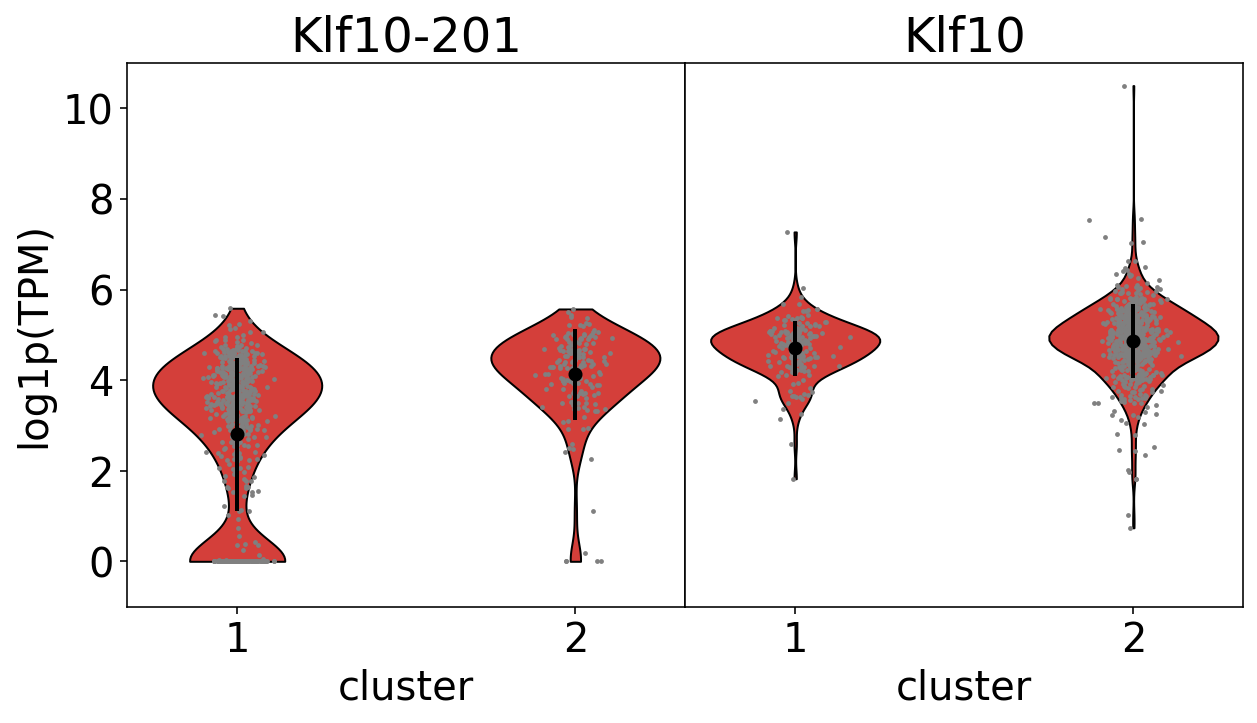

In [90]:
fig, axs = plt.subplots(figsize=(10, 5), ncols=2, sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)

km = np.unique(isoform.obs.km.values)
iso_vector = nd(isoform.layers["log1p"][:, isoform.var.index.values == i].todense())
gene_vector = nd(gene.layers["log1p"][:, gene.var.index.values == g].todense())

lidx = np.arange(len(km)) + 1
labels = [f"{i}" for i in lidx]
kwd = {
    "xticks" : lidx,
    "xticklabels": labels,
    "xlabel":"cluster",
    "ylim": (-1, 11),
    "ylabel": "log1p(TPM)"
}

ax = axs[0]
mask = isoform.obs.eval(f"km == '0'")
data = [iso_vector[mask], iso_vector[~mask]]

vplot(data, [], ax)

ax.set_title(f"{i.split('_')[0]}")
ax.set(**kwd)



ax = axs[1]
mask = gene.obs.eval(f"km == '0'")
data = [gene_vector[mask], gene_vector[~mask]]

vplot(data, [], ax)

ax.set_title(f"{g.split('_')[0]}")
kwd["yticks"] = []
kwd["yticklabels"] = []
kwd["ylabel"] = ""
ax.set(**kwd)

fig.show()

In [93]:
print("isoform: ",  4.124936992873991 - 2.8018342296648284)
print("gene:    ",     4.859678702615859 - 4.698899502858348)


isoform:  1.3231027632091625
gene:     0.16077919975751165


In [419]:
from scipy import spatial

In [421]:
spatial.distance.hamming(isoform.obs.km.values, gene.obs.km.values)

0.028761061946902654

In [422]:
isoform.obs[isoform.obs.km.values== gene.obs.km.values].shape

(878, 14)

In [423]:
isoform.shape

(904, 61873)

# effect sizes for all marker genes

In [101]:
def mean(matrix, features, feature, ):
    mask = features == feature
    v = nd(matrix[:,mask])
    
    return v.mean(), v.var()

In [95]:
mtx = gene.layers["log1p"].todense()

In [98]:
genes = gene.var.index.values

In [107]:
es = []
for gidx, g in enumerate(markers_gene.gene_name):
    m = []
    for k in np.unique(gene.obs.km.values):
        mask = gene.obs.eval(f"km == '{k}'")
        m.append(mean(mtx[mask], genes, g))
    es.append(abs(m[0][0] - m[1][0]))

In [108]:
markers_gene["es"] =  es

In [110]:
markers_gene.sort_values("es")

,index,gene_name,p_raw,p_bonferroni,gene,es
2382,1,Atp6v1d_ENSMUSG00000021114,9.89028e-08,0.00117605,Atp6v1d,0.079777
2249,1,Cfl1_ENSMUSG00000056201,2.88943e-13,3.43582e-09,Cfl1,0.087078
2379,1,Map1lc3a_ENSMUSG00000027602,8.65948e-08,0.0010297,Map1lc3a,0.088712
2413,1,Sdhb_ENSMUSG00000009863,2.66101e-07,0.0031642,Sdhb,0.095635
1333,0,Rab3a_ENSMUSG00000031840,5.71522e-12,6.79597e-08,Rab3a,0.096628
...,...,...,...,...,...,...
283,0,Cers1_ENSMUSG00000087408,1.10905e-37,1.31878e-33,Cers1,1.437282
153,0,Egln2_ENSMUSG00000058709,2.16596e-48,2.57554e-44,Egln2,1.441532
157,0,Stk32c_ENSMUSG00000015981,5.19769e-48,6.18057e-44,Stk32c,1.444380
216,0,Thop1_ENSMUSG00000004929,1.03487e-42,1.23057e-38,Thop1,1.452902


# effect sizes for all marker isoforms

In [112]:
markers_isoform

,index,transcript_name,p_raw,p_bonferroni,gene
0,0,Cox7a2-201_ENSMUST00000034881,1.55019e-66,4.79575e-62,Cox7a2
1,0,Cox7c-203_ENSMUST00000131011,1.86936e-66,5.78316e-62,Cox7c
2,0,Cox6b1-201_ENSMUST00000075738,1.38891e-65,4.29679e-61,Cox6b1
3,0,Cox6c-201_ENSMUST00000014457,7.17398e-65,2.21938e-60,Cox6c
4,0,Atp5l-201_ENSMUST00000043675,1.20259e-63,3.7204e-59,Atp5l
...,...,...,...,...,...
2213,1,Egr1-202_ENSMUST00000165033,2.79204e-07,0.00863759,Egr1
2214,1,Arf4-203_ENSMUST00000166075,2.84209e-07,0.00879242,Arf4
2215,1,Klf6-201_ENSMUST00000000080,3.05659e-07,0.00945601,Klf6
2216,1,Jmjd8-201_ENSMUST00000026832,3.11793e-07,0.00964579,Jmjd8


In [111]:
mtx = isoform.layers["log1p"].todense()

In [114]:
isoforms = isoform.var.index.values

In [115]:
es = []
for iidx, i in enumerate(markers_isoform.transcript_name):
    m = []
    for k in np.unique(isoform.obs.km.values):
        mask = isoform.obs.eval(f"km == '{k}'")
        m.append(mean(mtx[mask], isoforms, i))
    es.append(abs(m[0][0] - m[1][0]))

In [117]:
markers_isoform["es"] =  es

In [118]:
markers_isoform.sort_values("es")

,index,transcript_name,p_raw,p_bonferroni,gene,es
104,0,Vmn1r47-202_ENSMUST00000227229,3.26248e-27,1.0093e-22,Vmn1r47,0.080647
383,0,Eif1-201_ENSMUST00000049385,5.73627e-09,0.00017746,Eif1,0.085476
279,0,Cfl1-201_ENSMUST00000116560,3.13605e-12,9.70184e-08,Cfl1,0.085850
390,0,Cfl1-202_ENSMUST00000209469,9.92905e-09,0.00030717,Cfl1,0.086980
1938,1,Rab3a-201_ENSMUST00000034301,3.71894e-11,1.15051e-06,Rab3a,0.104133
...,...,...,...,...,...,...
537,1,Uba1-201_ENSMUST00000001989,1.97486e-73,6.10951e-69,Uba1,2.454222
632,1,Gria2-203_ENSMUST00000192463,7.00068e-55,2.16577e-50,Gria2,2.479189
689,1,Ptk2b-203_ENSMUST00000111121,2.20644e-49,6.82595e-45,Ptk2b,2.525565
536,1,Syt11-205_ENSMUST00000183267,1.48263e-73,4.58675e-69,Syt11,2.627207


0.6576826370631703
0.5547748185334826


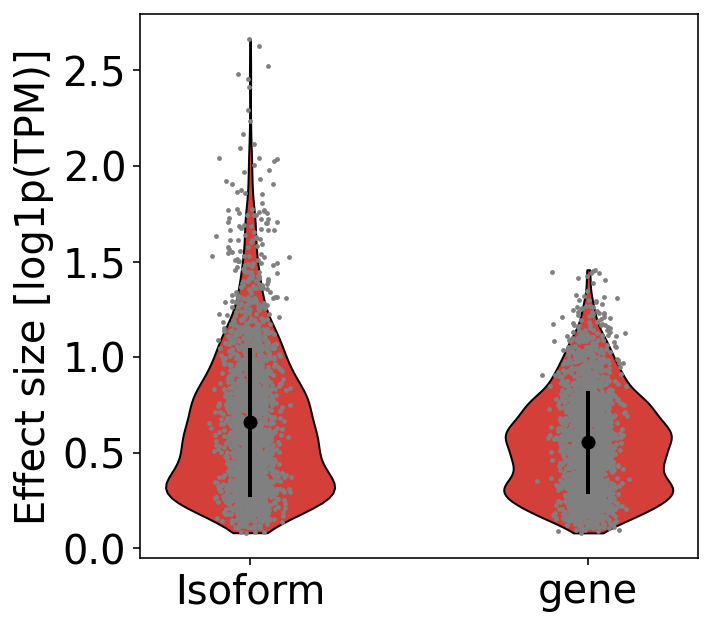

In [123]:
fig, ax = plt.subplots(figsize=(5,5))
labels = ["Isoform", "gene"]
lticks = np.arange(len(labels)) + 1
data = [markers_isoform["es"].values, markers_gene["es"].values]
vplot(data, [], ax)

ax.set(**{
    "xticklabels": labels,
    "xticks": lticks,
    "ylabel": "Effect size [log1p(TPM)]"
 })

fig.show()

In [148]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

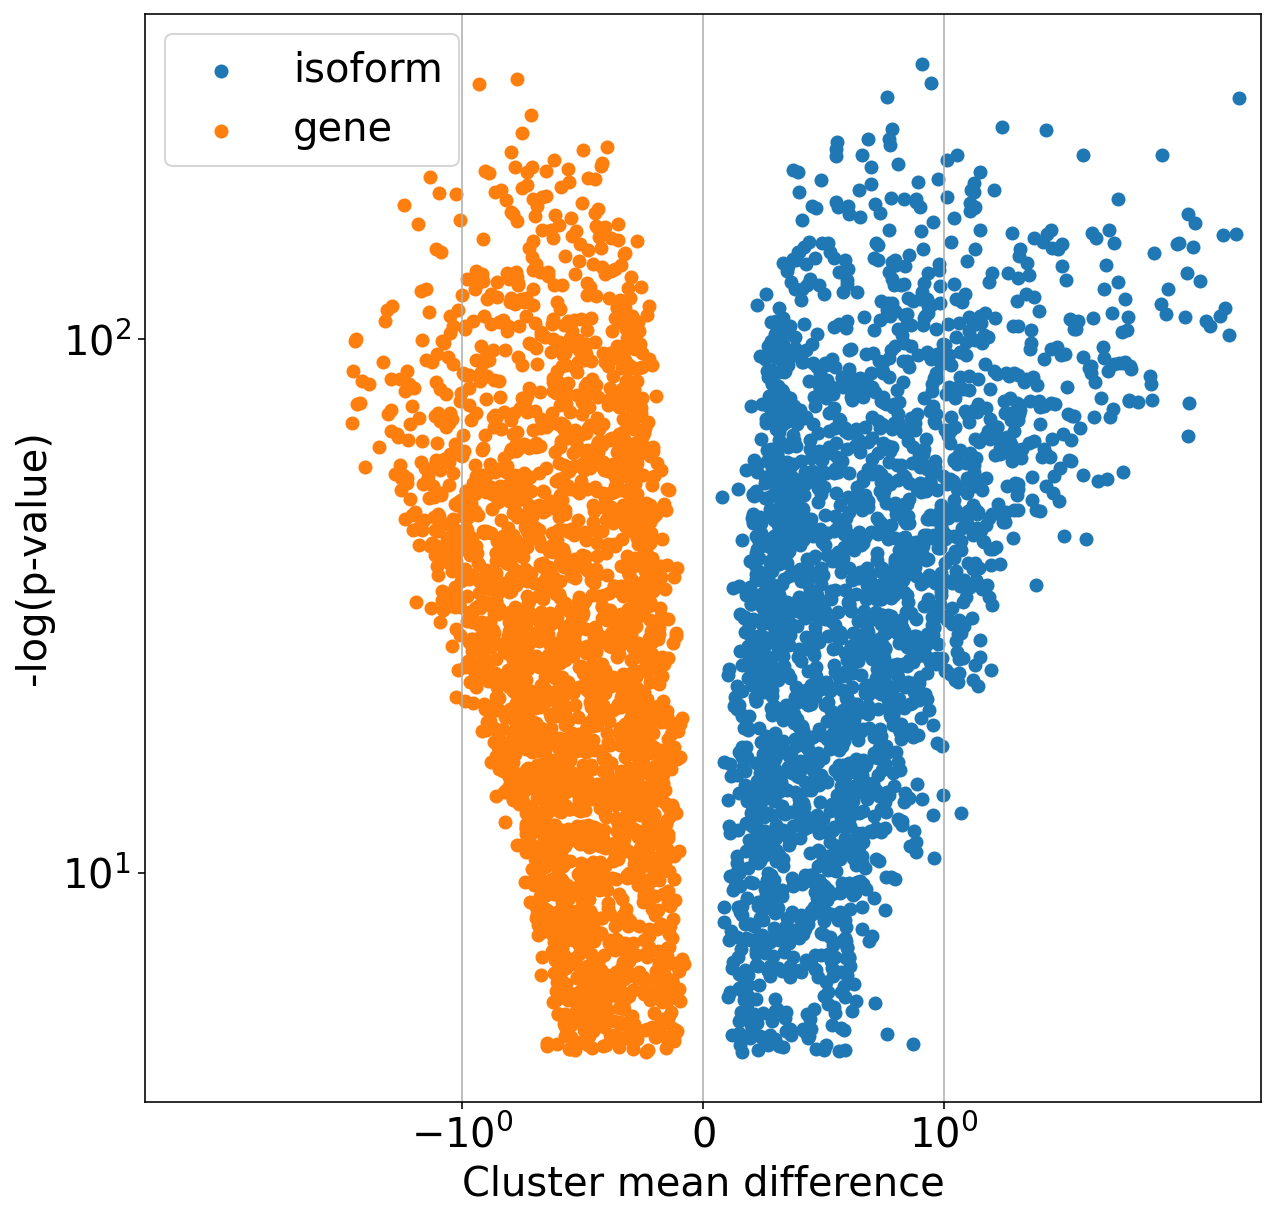

In [173]:
fig, ax = plt.subplots(figsize=(10,10))

x = markers_isoform["es"].values.astype(float)
y = -np.log(markers_isoform["p_bonferroni"].values.astype(float))

ax.scatter(x,y, label="isoform")

x = -markers_gene["es"].values.astype(float)
y = -np.log(markers_gene["p_bonferroni"].values.astype(float))

ax.scatter(x,y, label="gene")

ax.set(**{
    "xscale": "symlog",
    "yscale": "symlog",
    "xlim": (-3, 3),
    "xlabel": "Cluster mean difference",
    "ylabel": "-log(p-value)"
})
ax.xaxis.grid(True)
#ax.xaxis.set_minor_locator(MultipleLocator(.5))
#ax.xaxis.set_major_locator(MultipleLocator(2))
ax.legend()

fig.show()